In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

! pip install rasterio
! pip install geopandas
import rasterio
from rasterio.mask import mask
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
import geopandas as gpd

import os
from pprint import pprint
from tqdm.auto import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/G_drive')

Mounted at /content/G_drive


In [4]:
# change cwd
cwd = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_1_UNET_predict_future_urbanization'
os.chdir(cwd)

In [5]:
# append path so to load custom modules
import sys
sys.path.append('./torch_modules')

# might need reload modules as the code changes
%load_ext autoreload
%autoreload 2

# load global variables
from Global_Variables import proj_yr_selected

In [6]:
# read future urban pixel count data
future_urban_pixel = pd.read_csv('./result_csv/SSP_GDP_Pop_future_pred.csv')
future_urban_pixel = future_urban_pixel[future_urban_pixel['Scenario']!='Historical'].reset_index(drop=True)

# the admin shp and raster
admin_shp = gpd.read_file("../../Data/04_Vector_boundary/North_china_Plain_Province.shp")
UNET_ds = rasterio.open(f'./Simulated_Tif/trainsition_potential_{proj_yr_selected[0]}_{proj_yr_selected[1]}.tif')

In [7]:
future_urban_pixel

,Province,year,GDP,Pop,Scenario,count_pred,brms_future,brms_future_low,brms_future_high
0,Beijing,2020,36667.373449,2128.522419,SSP1,4.017919e+06,4.746241e+06,3.245355e+06,6.314330e+06
1,Tianjin,2020,14304.019307,1348.680034,SSP1,3.485637e+06,3.933562e+06,2.604657e+06,5.219414e+06
2,Hebei,2020,36773.305073,7257.784987,SSP1,2.306211e+07,2.277012e+07,2.128895e+07,2.438100e+07
3,Jiangsu,2020,104325.891579,8242.797875,SSP1,2.686352e+07,2.685622e+07,2.490992e+07,2.844911e+07
4,Anhui,2020,39285.702565,5936.331370,SSP1,1.675230e+07,1.669025e+07,1.522190e+07,1.809044e+07
...,...,...,...,...,...,...,...,...,...
590,Hebei,2100,184361.789888,3411.728643,SSP5,5.798455e+07,6.215160e+07,4.544932e+07,9.109145e+07
591,Jiangsu,2100,523034.523682,3874.762019,SSP5,8.707517e+07,8.426283e+07,4.451385e+07,1.044681e+08
592,Anhui,2100,196957.614431,2790.541716,SSP5,4.637384e+07,4.851599e+07,3.945723e+07,6.047351e+07
593,Shandong,2100,372365.304202,4646.331948,SSP5,8.586648e+07,8.832780e+07,6.172311e+07,1.108338e+08


### Compute the allocation-threshold of future urbanization

In [ ]:
# loop through each shp records
pixel_count_threshold = {}

for idx,row in tqdm(admin_shp.iterrows(),total=len(admin_shp)):
  
  # get infos
  province = row['EN_Name']
  geom = row['geometry']
  province_df = future_urban_pixel[future_urban_pixel['Province']==province]

  # convert geom to Geojson to clip raster
  geojson = [gpd.GeoSeries(geom).__geo_interface__['features'][0]['geometry']]

  # clip the admin raster
  clipped_array, clipped_transform = mask(dataset=UNET_ds, shapes=geojson, crop=True)

  # change background value to 0
  clipped_array = np.where(clipped_array>10000,0,clipped_array)

  # build the histogram df
  count,bins = np.histogram(clipped_array,range(10002))
  histo_df = pd.DataFrame({'val':bins[:-1],'count':count})
  histo_df.sort_values('val',ascending=False,inplace=True)
  histo_df['cumsum'] = histo_df['count'].cumsum()
  
  # loop through each SSP
  for ssp_idx, ssp_row in province_df.iterrows():

    # get infos
    ssp = ssp_row['Scenario']
    year = ssp_row['year']

    ssp_count = ssp_row['brms_future']
    ssp_count_bot = ssp_row['brms_future_low']
    ssp_count_top = ssp_row['brms_future_high']
    
    # find the threshold val
    histo_df['distance'] = abs(histo_df['cumsum']/ssp_count - 1)
    histo_df['distance_bot'] = abs(histo_df['cumsum']/ssp_count_bot - 1)
    histo_df['distance_top'] = abs(histo_df['cumsum']/ssp_count_top - 1)

    threshold   = histo_df[histo_df['distance'] == histo_df['distance'].min()]['val'].values[0]
    threshold_bot = histo_df[histo_df['distance_bot'] == histo_df['distance_bot'].min()]['val'].values[0]
    threshold_top = histo_df[histo_df['distance_top'] == histo_df['distance_top'].min()]['val'].values[0]

    # record the threshold
    pixel_count_threshold[(province,year,ssp,'threshold')] = [threshold]
    pixel_count_threshold[(province,year,ssp,'threshold_bot')] = [threshold_bot]
    pixel_count_threshold[(province,year,ssp,'threshold_top')] = [threshold_top]

  0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
# # # store the threshold data to a df
# pixel_count_threshold_df = pd.DataFrame(pixel_count_threshold).T.reset_index()
# pixel_count_threshold_df.columns = ['Province','year','Scenario','Threshold_type','val']

# # seperate the threshold columns
# pixel_count_threshold_df = pixel_count_threshold_df.pivot(index=['Province','year','Scenario'],columns='Threshold_type').reset_index()
# pixel_count_threshold_df.columns = [i[0] if not i[1] else i[1] for i in pixel_count_threshold_df.columns]
# pixel_count_threshold_df.to_csv('./result_csv/SSP_GDP_Pop_future_pred_treshold.csv',index=False)

pixel_count_threshold_df = pd.read_csv('./result_csv/SSP_GDP_Pop_future_pred_treshold.csv')
pixel_count_threshold_df

,Province,year,Scenario,threshold,threshold_bot,threshold_top
0,Anhui,2020,SSP1,8054,9942,7399
1,Anhui,2020,SSP2,8093,9940,7433
2,Anhui,2020,SSP3,8105,9941,7455
3,Anhui,2020,SSP4,8143,9948,7477
4,Anhui,2020,SSP5,7997,9937,7345
...,...,...,...,...,...,...
590,Tianjin,2100,SSP1,3492,9977,193
591,Tianjin,2100,SSP2,3613,9975,287
592,Tianjin,2100,SSP3,6259,9981,2862
593,Tianjin,2100,SSP4,5272,9988,928


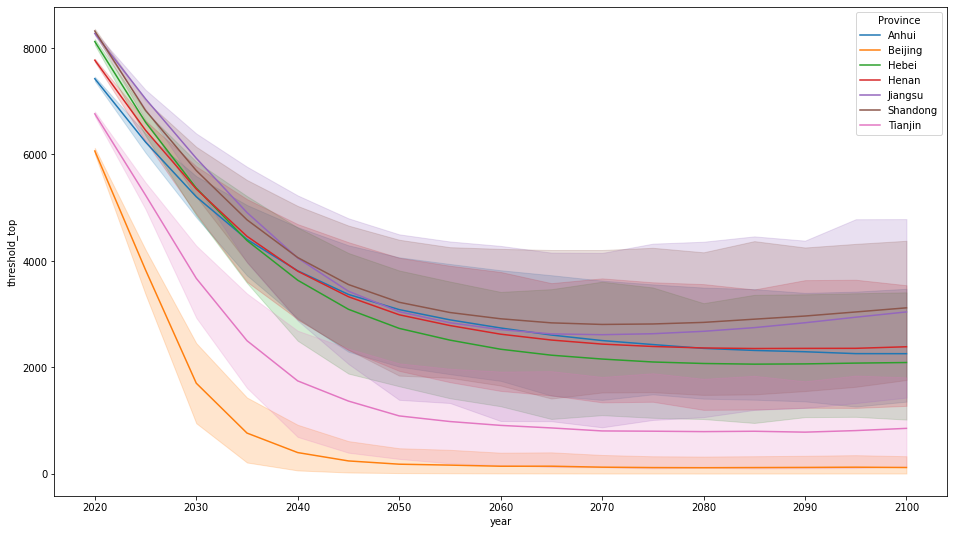

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(data=pixel_count_threshold_df,x='year',y='threshold_top',hue='Province')